<p align="center">
  <img src="./screenshots/logo.gif" alt="logo 404 Brain Not Found">
</p>

## 📌 Projekt: Benchmark modeli wizji komputerowej i VLLMów do klasyfikacji obrazów medycznych

### 🎯 Cel projektu
Celem projektu jest przeprowadzenie **benchmarku** polegającego na porównaniu, jak różne modele radzą sobie z klasyfikacją tych samych obrazów (ze szczególnym uwzględnieniem obrazów medycznych).  
Do eksperymentów wykorzystujemy zarówno **Konwolucyjne sieci neuronowe(CNN)** oraz architektury na nich bazujące , jak i **modele wizualno-językowe (Visual LLM, VLLM)** dostępne jako rozwiązania open-source na platformie [Hugging Face](https://huggingface.co).

---

### 🔬 Scenariusz badawczy
1. **Klasyfikacja obrazu przez modele wizji komputerowej** – input unimodalny (obraz → sieć konwolucyjna/transformer wyodrębnia cechy → warstwa klasyfikacyjna mapuje je na etykiety).
2. **Klasyfikacja obrazu przez VLLM** – input multimodalny (obraz + prompt → fine tuning modeli tak, by klasyfikowały obrazy).  
3. **Analiza różnic jakościowych** – porównanie wyników automatycznych (metryki) i jakościowych (ocena ekspercka).

---

### 🧪 Modele rozważane w projekcie

#### 1. Visual LLM (VLLM)
- **Modele BLIP (Salesforce)**  
  - `blip-image-captioning-base` – lekki, możliwy do modyfikacji (np. zamiana warstwy wyjściowej na klasyfikator).  
  - `blip-vqa-base` – zadanie można sformułować jako pytanie *„Czy na obrazie jest guz typu X?”* → model odpowiada *tak/nie*.  
  - `blip-itm-base-coco` / `blip-itm-base-flickr` – użycie jako ekstraktora cech wizualnych z dodatkową warstwą klasyfikacyjną.  
  - Większe modele BLIP (captioning-large, vqa-capfilt-large, itm-large) są zasobożerne, więc mniej praktyczne.  

- **Inne modele multimodalne**  
  - `deepseek-vl-7b-base`  
  - `Qwen-VL`  
  - `moondream2`  

#### 2. Klasyczne modele wizji komputerowej
- CNN oraz Vision Transformer (np. EfficientNet, Swin Transformer z biblioteki `timm`).  
- Możliwość pełnego fine-tuning pod kątem danych medycznych.  
- Hipoteza: klasyczne modele mogą być bardziej skuteczne do klasyfikacji obrazów medycznych i szybsze od VLLM.  

---

### ⚙️ Fine-tuning
- **LoRA / PEFT** – umożliwia trenowanie tylko niewielkiej części parametrów, oszczędzając pamięć i zasoby obliczeniowe.  
- Konieczny, ponieważ większość modeli nie była uczona na danych medycznych → potrzebna adaptacja do specyfiki obrazów MRI.  

---

### 📊 Ewaluacja
- **Metryki automatyczne**: BLEU, ROUGE, METEOR, CIDEr, SPICE.  
- **CLIPScore** – porównanie embeddingów obrazu i wygenerowanego opisu.  
- **Ocena ekspercka** – subiektywna analiza jakości opisów (np. zgodność z obrazem, przydatność kliniczna).  

---

### 📚 Różnice między kluczowymi modelami
- **CLIP**: odpowiada na pytanie *„Czy obraz pasuje do tekstu?”* → sprawdza zgodność.  
- **BLIP**: potrafi **tworzyć opisy obrazów**, nie tylko oceniać dopasowanie.  

---

### 📂 Dodatkowe materiały
- [Hugging Face – kolekcja BLIP](https://huggingface.co/collections/Salesforce/blip-models65242f40f1491fbf6a9e9472)  
- [Hugging Face Blog – Visual LLMs (2025)](https://huggingface.co/blog/vlms-2025)  
- [Hugging Face Blog – VLMs](https://huggingface.co/blog/vlms)  
- [Artykuł – Vision Transformer w klasyfikacji obrazów](https://medium.com/@sanjay_dutta/flower-image-classification-using-visiontransformer-vit-50b71694cda3)  


---

### ✅ Podsumowanie
Projekt zakłada porównanie **różnych podejść do opisu obrazów medycznych**:  
- klasycznych modeli wizji komputerowej,  
- Visual LLM (modele multimodalne),  


Efektem będzie **benchmark** wskazujący, które podejście sprawdza się najlepiej w zadaniu opisu obrazów MRI, jakie są ich mocne i słabe strony oraz jakie kompromisy wydajnościowe i jakościowe się pojawiają.  


In [ ]:
import os
import shutil
from pathlib import Path
import kaggle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import random




2025-09-14 20:13:03.342335: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
SEED = 900729
dir_path = './data'
train_path = './data/Training'
test_path = './data/Testing'
if os.path.exists(dir_path):
    print("Dane juz istnieją")
else:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('masoudnickparvar/brain-tumor-mri-dataset', path='./data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
tr_orginal_df = train_df(train_path)
tr_orginal_df

,Class Path,Class
0,./data/Training/notumor/Tr-no_0787.jpg,notumor
1,./data/Training/notumor/Tr-no_0348.jpg,notumor
2,./data/Training/notumor/Tr-no_1580.jpg,notumor
3,./data/Training/notumor/Tr-no_0389.jpg,notumor
4,./data/Training/notumor/Tr-no_0857.jpg,notumor
...,...,...
5707,./data/Training/pituitary/Tr-pi_0448.jpg,pituitary
5708,./data/Training/pituitary/Tr-pi_1089.jpg,pituitary
5709,./data/Training/pituitary/Tr-pi_1135.jpg,pituitary
5710,./data/Training/pituitary/Tr-pi_1121.jpg,pituitary


In [ ]:
ts_orginal_df = test_df(test_path)
ts_orginal_df

,Class Path,Class
0,./data/Testing/notumor/Te-no_0058.jpg,notumor
1,./data/Testing/notumor/Te-noTr_0006.jpg,notumor
2,./data/Testing/notumor/Te-no_0202.jpg,notumor
3,./data/Testing/notumor/Te-noTr_0003.jpg,notumor
4,./data/Testing/notumor/Te-no_0221.jpg,notumor
...,...,...
1306,./data/Testing/pituitary/Te-pi_0248.jpg,pituitary
1307,./data/Testing/pituitary/Te-pi_0042.jpg,pituitary
1308,./data/Testing/pituitary/Te-pi_0273.jpg,pituitary
1309,./data/Testing/pituitary/Te-pi_0297.jpg,pituitary


### Przed podziałem

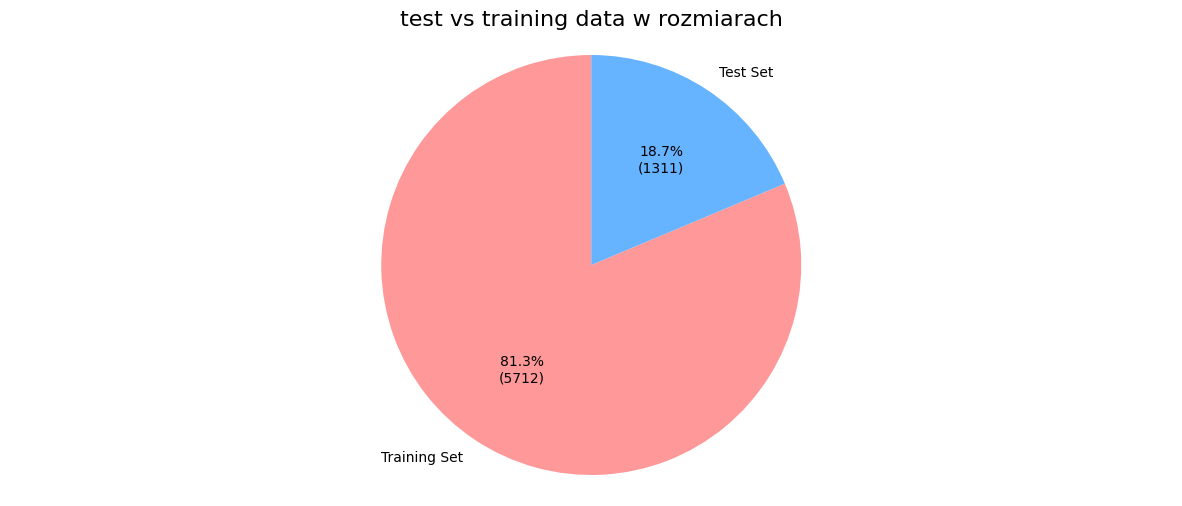

In [ ]:
plt.figure(figsize=(15,6))
sizes = [tr_orginal_df.Class.size, ts_orginal_df.Class.size]
labels = ['Training Set', 'Test Set']
colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(sizes))})', startangle=90)
plt.title('test vs training data w rozmiarach', fontsize=16)
plt.axis('equal')
plt.show()

Wykres kołowy przedstawia porównanie wielkości zbiorów danych w projekcie klasyfikacji guzów mózgu przed jakimkolwiek podziałem na podzbiory. Widać znaczną **przewagę datasetu treningowego** nad testowym. Stanowi on punkt wyjścia dla dalszej analizy i podziału danych na potrzeby trenowania modeli do klasyfikacji guzów mózgu 🧠

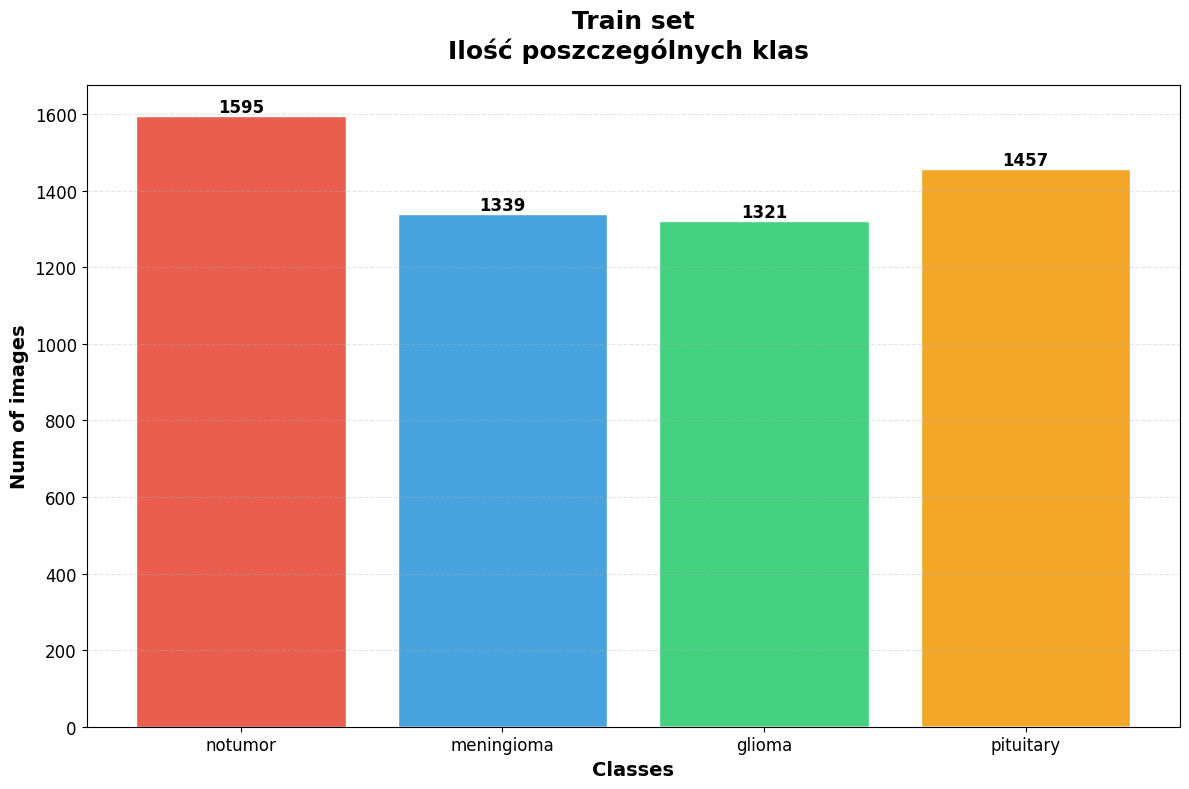

In [ ]:
plt.figure(figsize=(12, 8))

colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

ax = sns.histplot(data=tr_orginal_df, x='Class', hue='Class',
                  discrete=True,
                  shrink=0.8,
                  palette=colors,
                  edgecolor='white',
                  alpha=0.9,
                  legend=False)

plt.xlabel('Classes', fontsize=14, fontweight='bold')
plt.ylabel('Num of images', fontsize=14, fontweight='bold')
plt.title('Train set\nIlość poszczególnych klas ', fontsize=18, fontweight='bold', pad=20)

for container in ax.containers:
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, fontsize=12, fontweight='bold')


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.35, linestyle='--')
plt.tight_layout()
plt.show()

Na wykresie widać rozkład liczby obrazów w zbiorze treningowym dla 4 klas:  

- **notumor**: 1595 obrazów  
- **meningioma**: 1339 obrazów  
- **glioma**: 1321 obrazów  
- **pituitary**: 1457 obrazów  

---

#### 1. Balans klas
- Dane są stosunkowo dobrze zbalansowane – różnice między najmniejszą (glioma – 1321) a największą klasą (notumor – 1595) to ok. **20%**
- Nie ma bardzo dużej nierównowagi, więc modele nie powinien faworyzować jednej klasy w sposób drastyczny

---

#### 2. Wpływ na uczenie maszynowe
- Dzięki zbliżonej liczbie próbek w każdej klasie, **model będzie miał szansę nauczyć się cech wszystkich typów** w miarę równomiernie
- Minimalne różnice w liczności mogą jednak powodować, że modele **lekko preferuje klasę „notumor”**, bo ma jej najwięcej przykładów  
- W przypadku niewystarczającej regularizacji lub złego doboru metryk (np. tylko accuracy), może to prowadzić do **biasu w stronę klas liczniejszych**

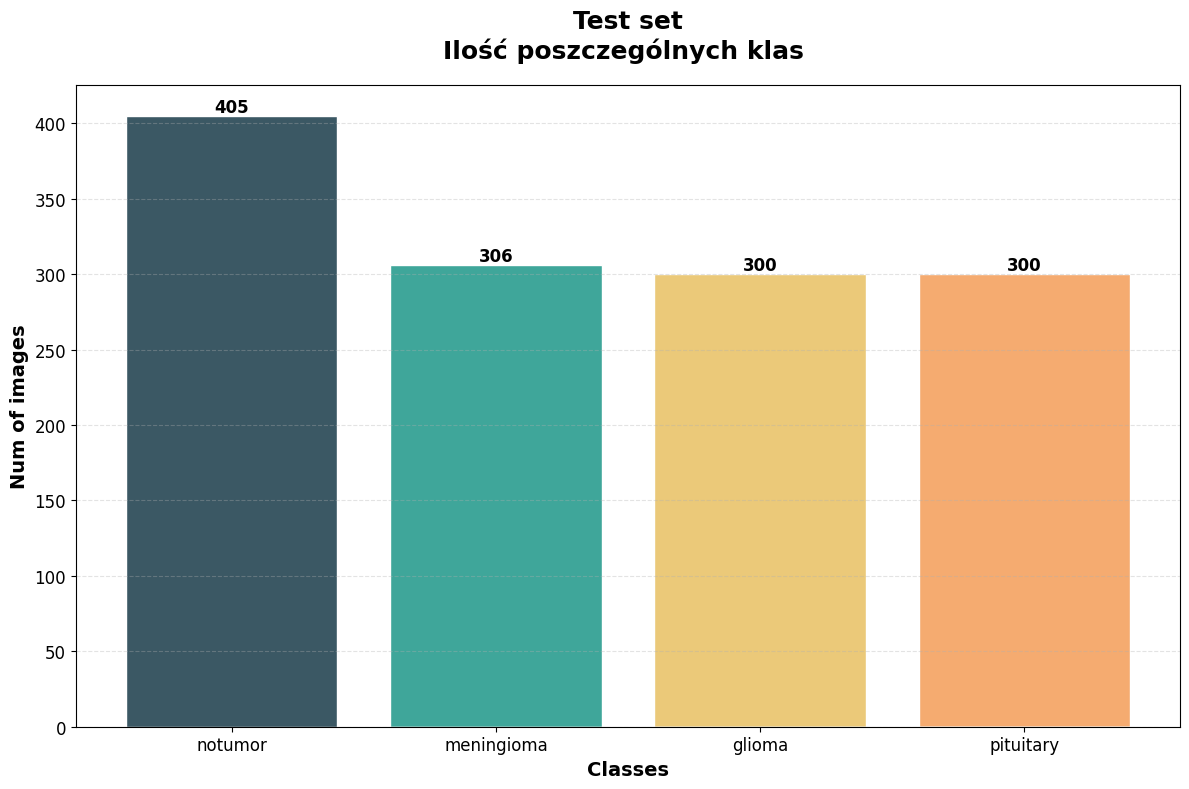

In [ ]:
plt.figure(figsize=(12, 8))

colors = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261']

ax = sns.histplot(data=ts_orginal_df, x='Class', hue='Class',
                  discrete=True,
                  shrink=0.8,
                  palette=colors,
                  edgecolor='white',
                  alpha=0.9,
                  legend=False)

plt.xlabel('Classes', fontsize=14, fontweight='bold')
plt.ylabel('Num of images', fontsize=14, fontweight='bold')
plt.title('Test set\nIlość poszczególnych klas ', fontsize=18, fontweight='bold', pad=20)

for container in ax.containers:
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, fontsize=12, fontweight='bold')


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.35, linestyle='--')
plt.tight_layout()
plt.show()

Na wykresie widać rozkład liczby obrazów w zbiorze testowym dla 4 klas:  

- **notumor**: 405 obrazów  
- **meningioma**: 306 obrazów  
- **glioma**: 300 obrazów  
- **pituitary**: 300 obrazów  

---

### 1. Balans klas
- Zbiór testowy jest stosunkowo dobrze zbalansowany.  
- Różnica między najmniejszą (glioma/pituitary – 300) a największą klasą (notumor – 405) to ok. **26%**.  
- Klasa *notumor* ma wyraźnie więcej przykładów, co może lekko wpłynąć na metryki globalne.  

---

### 2. Wpływ na końcowy wynik (accuracy)
- Ponieważ accuracy liczy wszystkie próbki razem, większa liczność klasy **notumor** sprawi, że błędy w tej klasie będą miały większy wpływ na końcową dokładność niż błędy w pozostałych klasach.  
- Model, który dobrze przewiduje *notumor*, może osiągać **sztucznie zawyżone accuracy**, nawet jeśli gorzej radzi sobie z mniejszymi klasami (*glioma*, *meningioma*, *pituitary*).  
- To może prowadzić do **nierównomiernej jakości klasyfikacji** – użytkownik widzi wysokie accuracy, ale np. F1-score dla mniejszych klas jest dużo niższy.  


## Po podziale


In [ ]:
val_df, tr_df = train_test_split(tr_orginal_df, train_size=0.25, random_state=SEED, stratify=tr_orginal_df['Class'])

validation_path = './data/Validation'
Path(validation_path).mkdir(exist_ok=True)

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
for class_name in classes:
    class_validation_path = Path(validation_path) / class_name
    class_validation_path.mkdir(exist_ok=True)

errors = []

for idx, row in val_df.iterrows():
    try:
        source_path = Path(row['Class Path'])

        filename = source_path.name
        class_name = row['Class']
        destination_path = Path(validation_path) / class_name / filename

        shutil.move(str(source_path), str(destination_path))

    except Exception as e:
        errors.append({
            'file': row['Class Path'],
            'class': row['Class'],
            'error': str(e)
        })


if errors:
    print(f"Errors: {len(errors)}")
    for error in errors:
        print(f"  - {error['class']}: {Path(error['file']).name} - {error['error']}")

val_df_updated = val_df.copy()
val_df_updated['Class Path'] = val_df_updated.apply(
    lambda row: str(Path(validation_path) / row['Class'] / Path(row['Class Path']).name),
    axis=1
)

tr_df_updated = train_df(train_path)

val_df = val_df_updated
tr_df = tr_df_updated

val_df

,Class Path,Class
1907,data/Validation/meningioma/Tr-me_0902.jpg,meningioma
721,data/Validation/notumor/Tr-no_0516.jpg,notumor
4069,data/Validation/glioma/Tr-gl_1161.jpg,glioma
4089,data/Validation/glioma/Tr-gl_0984.jpg,glioma
3478,data/Validation/glioma/Tr-gl_0162.jpg,glioma
...,...,...
4602,data/Validation/pituitary/Tr-pi_0638.jpg,pituitary
2442,data/Validation/meningioma/Tr-me_0983.jpg,meningioma
1681,data/Validation/meningioma/Tr-me_0587.jpg,meningioma
2815,data/Validation/meningioma/Tr-me_0457.jpg,meningioma


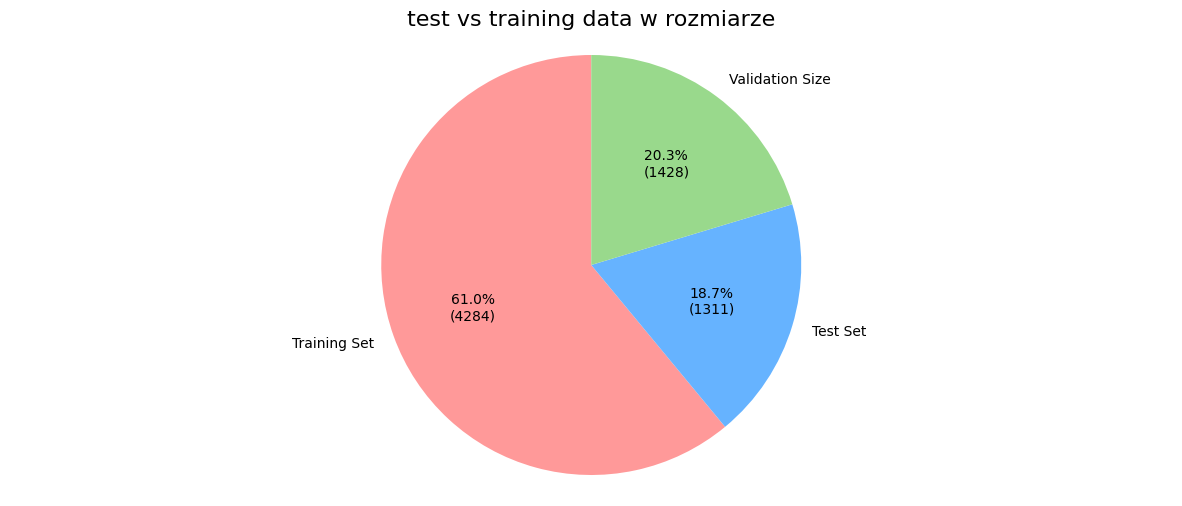

In [ ]:
plt.figure(figsize=(15,6))
sizes = [tr_df.Class.size, ts_orginal_df.Class.size, val_df.Class.size]
labels = ['Training Set', 'Test Set', 'Validation Size']
colors = ['#ff9999', '#66b3ff', "#99d98c"]

plt.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(sizes))})', startangle=90)
plt.title('test vs training data w rozmiarze', fontsize=16)
plt.axis('equal')
plt.show()

Zabraliśmy 25% zbioru treningowego na rzecz zbioru walidacyjnego finalnie mamy prawie podział zbioru zasdą 60:20:20

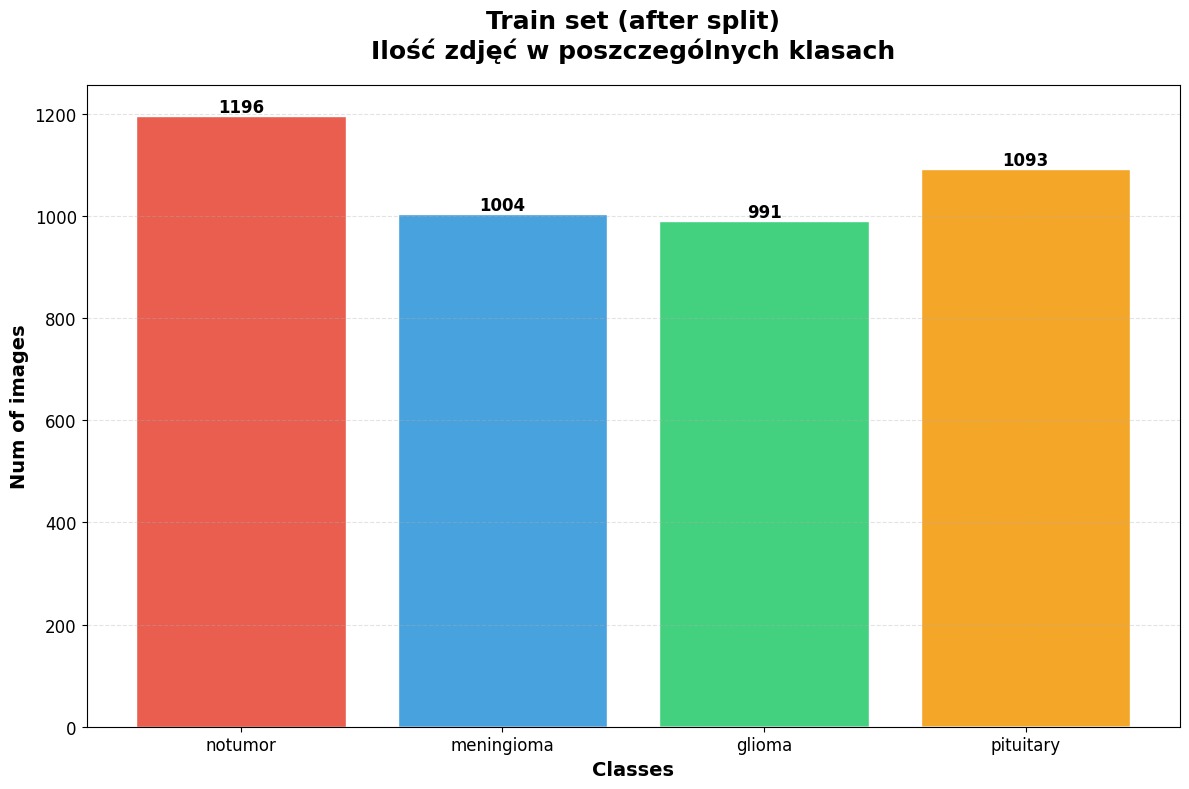

In [ ]:
plt.figure(figsize=(12, 8))

colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

ax = sns.histplot(data=tr_df, x='Class', hue='Class',
                  discrete=True,
                  shrink=0.8,
                  palette=colors,
                  edgecolor='white',
                  alpha=0.9,
                  legend=False)

plt.xlabel('Classes', fontsize=14, fontweight='bold')
plt.ylabel('Num of images', fontsize=14, fontweight='bold')
plt.title('Train set (after split)\nIlość zdjęć w poszczególnych klasach', fontsize=18, fontweight='bold', pad=20)

for container in ax.containers:
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, fontsize=12, fontweight='bold')


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.35, linestyle='--')
plt.tight_layout()
plt.show()

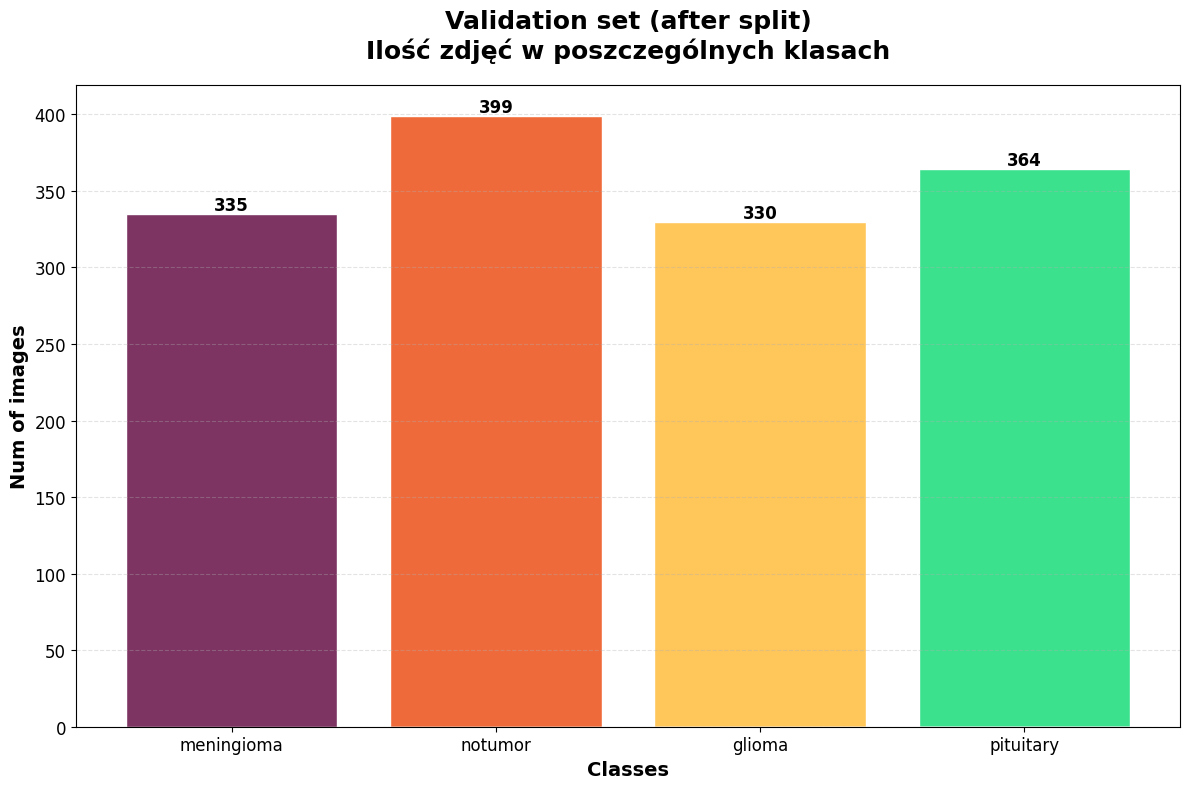

In [ ]:
plt.figure(figsize=(12, 8))

colors = ['#6F1E51', '#EE5A24', '#FFC048', '#26de81']

ax = sns.histplot(data=val_df, x='Class', hue='Class',
                  discrete=True,
                  shrink=0.8,
                  palette=colors,
                  edgecolor='white',
                  alpha=0.9,
                  legend=False)

plt.xlabel('Classes', fontsize=14, fontweight='bold')
plt.ylabel('Num of images', fontsize=14, fontweight='bold')
plt.title('Validation set (after split)\nIlość zdjęć w poszczególnych klasach', fontsize=18, fontweight='bold', pad=20)

for container in ax.containers:
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, fontsize=12, fontweight='bold')


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.35, linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
extensions = []

for root, _, files in os.walk(dir_path):
    for file in files:
        _, ext = os.path.splitext(file.lower())
        extensions.append(ext)

extension_counts = {}
for ext in extensions:
    extension_counts[ext] = extension_counts.get(ext, 0) + 1

total_files = len(extensions)

for ext, count in sorted(extension_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total_files) * 100
    print(f"{ext}: {count} plików ({percentage:.1f}%)")

print(f"\nŁączna liczba plików obrazów: {total_files}")

.jpg: 7023 plików (100.0%)

Łączna liczba plików obrazów: 7023


Wszystkie pliki są w tym samym formacie

## Immage size

In [ ]:
sizes = {}

for root, _, files in os.walk(dir_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(root, file)
            try:
                with Image.open(path) as img:
                    sizes[img.size] = sizes.get(img.size, 0) + 1
            except Exception as e:
                print(f"Błąd w pliku {path}: {e}")

print("Unikalne rozmiary obrazów:")
for size, count in sorted(sizes.items(), key=lambda x: x[1], reverse=True):
    print(f"{size} -> {count} plików")


Unikalne rozmiary obrazów:
(512, 512) -> 4742 plików
(225, 225) -> 332 plików
(630, 630) -> 90 plików
(236, 236) -> 81 plików
(201, 251) -> 58 plików
(228, 221) -> 51 plików
(232, 217) -> 50 plików
(300, 168) -> 49 plików
(442, 442) -> 46 plików
(150, 198) -> 44 plików
(200, 252) -> 43 plików
(428, 417) -> 42 plików
(227, 222) -> 39 plików
(173, 201) -> 36 plików
(206, 244) -> 35 plików
(192, 192) -> 31 plików
(256, 256) -> 31 plików
(201, 250) -> 29 plików
(218, 231) -> 29 plików
(215, 234) -> 28 plików
(227, 262) -> 27 plików
(468, 444) -> 24 plików
(208, 242) -> 24 plików
(359, 449) -> 23 plików
(504, 540) -> 23 plików
(642, 361) -> 22 plików
(214, 236) -> 22 plików
(400, 442) -> 20 plików
(236, 213) -> 19 plików
(393, 400) -> 18 plików
(207, 243) -> 18 plików
(442, 454) -> 17 plików
(276, 326) -> 17 plików
(230, 282) -> 17 plików
(420, 280) -> 17 plików
(235, 214) -> 16 plików
(550, 664) -> 16 plików
(441, 442) -> 16 plików
(680, 680) -> 15 plików
(194, 259) -> 15 plików
(339, 340)

## W zbiorze danych występują obrazy o różnych rozdzielczościach.
### Dlaczego to problem?
- Sieci neuronowe oczekują wejścia o **jednolitej wielkości**, np. `(224, 224)` lub `(256, 256)`.  
- Różne rozdzielczości mogą powodować:
  - błędy w batchach podczas treningu,  
  - brak spójności w ekstrakcji cech,  
  - trudności w konwergencji modelu.  

---

### Rozwiązanie – normalizacja obrazów
1. **Resize (skalowanie)** – wszystkie obrazy należy przeskalować do jednej wspólnej rozdzielczości (np. `224x224` lub `256x256`).  
2. **Zachowanie proporcji** – można używać `resize with padding` (dodanie pustych pikseli), aby nie deformować obrazów.  
3. **Normalizacja wartości pikseli** – oprócz rozmiaru, typowym krokiem jest też przeskalowanie wartości pikseli do zakresu `[0, 1]` lub standaryzacja (`mean`, `std`).  


### Wpływ na uczenie maszynowe
- Ujednolicenie rozmiarów sprawia, że **model otrzymuje dane w tym samym formacie**, co poprawia stabilność uczenia.  
- Dzięki temu konwolucje mogą poprawnie wychwytywać wzorce niezależnie od oryginalnej rozdzielczości.  
- Bez tego kroku mogłoby dojść do **niepoprawnych batchy i spadku accuracy**.

# Rodzaje raków

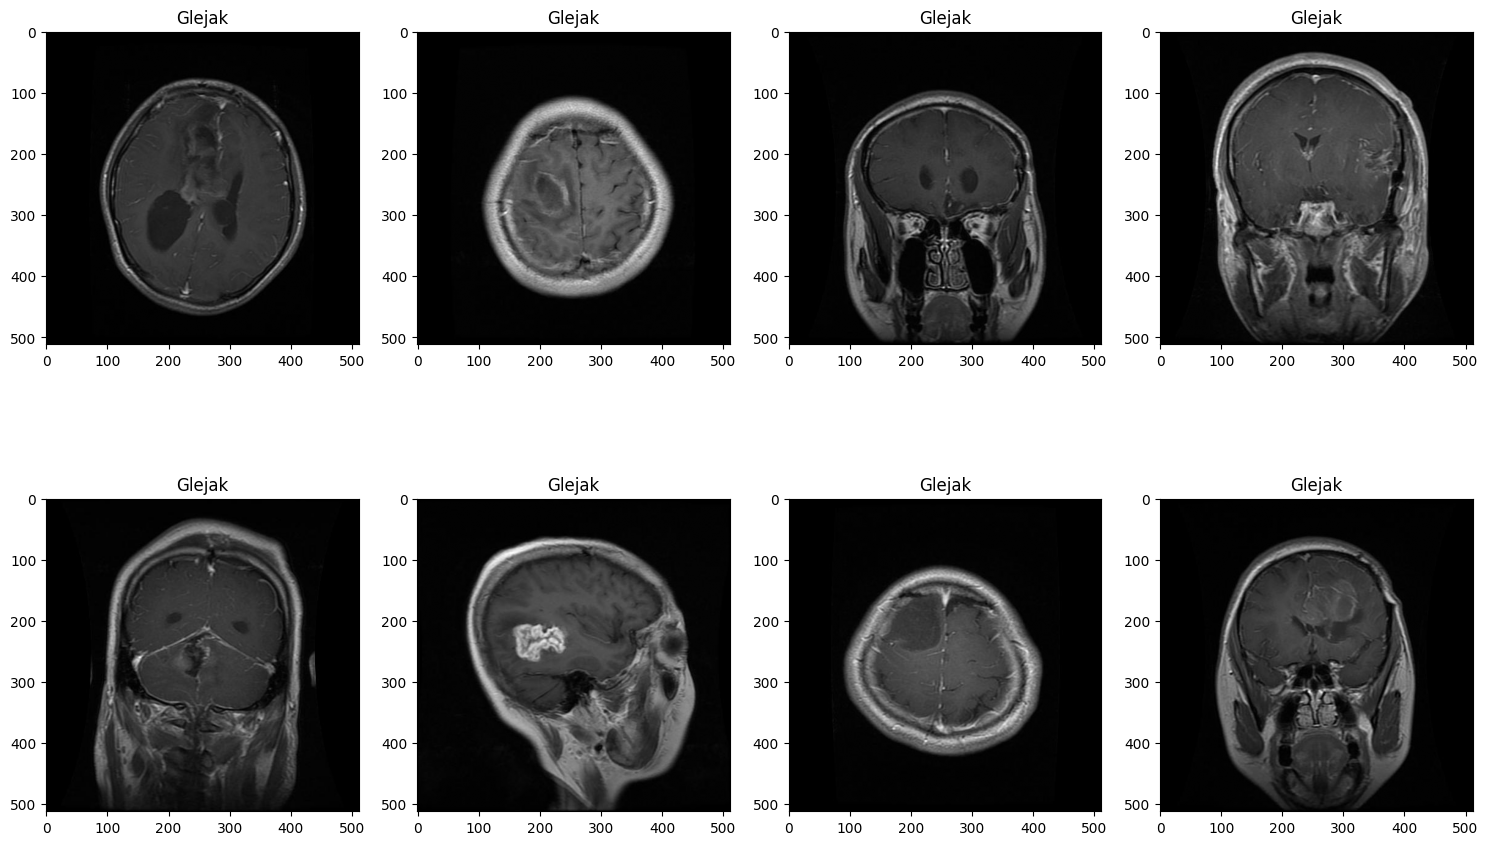

In [ ]:
glioma_paths = tr_df[tr_df['Class'] == 'glioma']['Class Path'].tolist()
random.seed(SEED)
random_glioma_paths = random.sample(glioma_paths, 8)

plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = Image.open(glioma_paths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f'Glejak')
plt.tight_layout()
plt.show()

# Glejak (Glioma)🦠

**Glejak** to jeden z najczęstszych nowotworów złośliwych mózgu, powstający z komórek glejowych, które wspierają i chronią neurony. Może rozwijać się w różnych częściach mózgu, a jego przebieg i rokowania zależą od stopnia złośliwości (WHO grade I–IV).

---

## Obrazowanie

- **Rezonans magnetyczny (MRI)** jest podstawowym narzędziem diagnostycznym.  
- Glejak na obrazach MRI często charakteryzuje się:
  - **niejednorodnym sygnałem** – obszary o różnej intensywności w zależności od obecności martwicy, krwotoków lub obrzęku,  
  - **niewyraźnymi granicami** – guz często „rozlewa się” w tkankę mózgową,  
  - **efektem masy** – ucisk na sąsiednie struktury, przesunięcie linii środkowej mózgu,  
  - w kontrastowych sekwencjach – **wzmacnianiem kontrastowym** w obszarach aktywnego wzrostu guza.  

---

## Diagnostyka i na co zwracają uwagę lekarze

1. **Lokalizacja i rozległość** guza w mózgu.  
2. **Stopień naciekania** – czy guz wnika w sąsiednie tkanki.  
3. **Obecność obrzęku okołoguzowego**.  
4. **Charakter wzmocnienia kontrastowego** – nieregularne, asymetryczne, wskazuje na większą złośliwość.  
5. **Wpływ na struktury krytyczne** (np. pień mózgu, istota biała).  



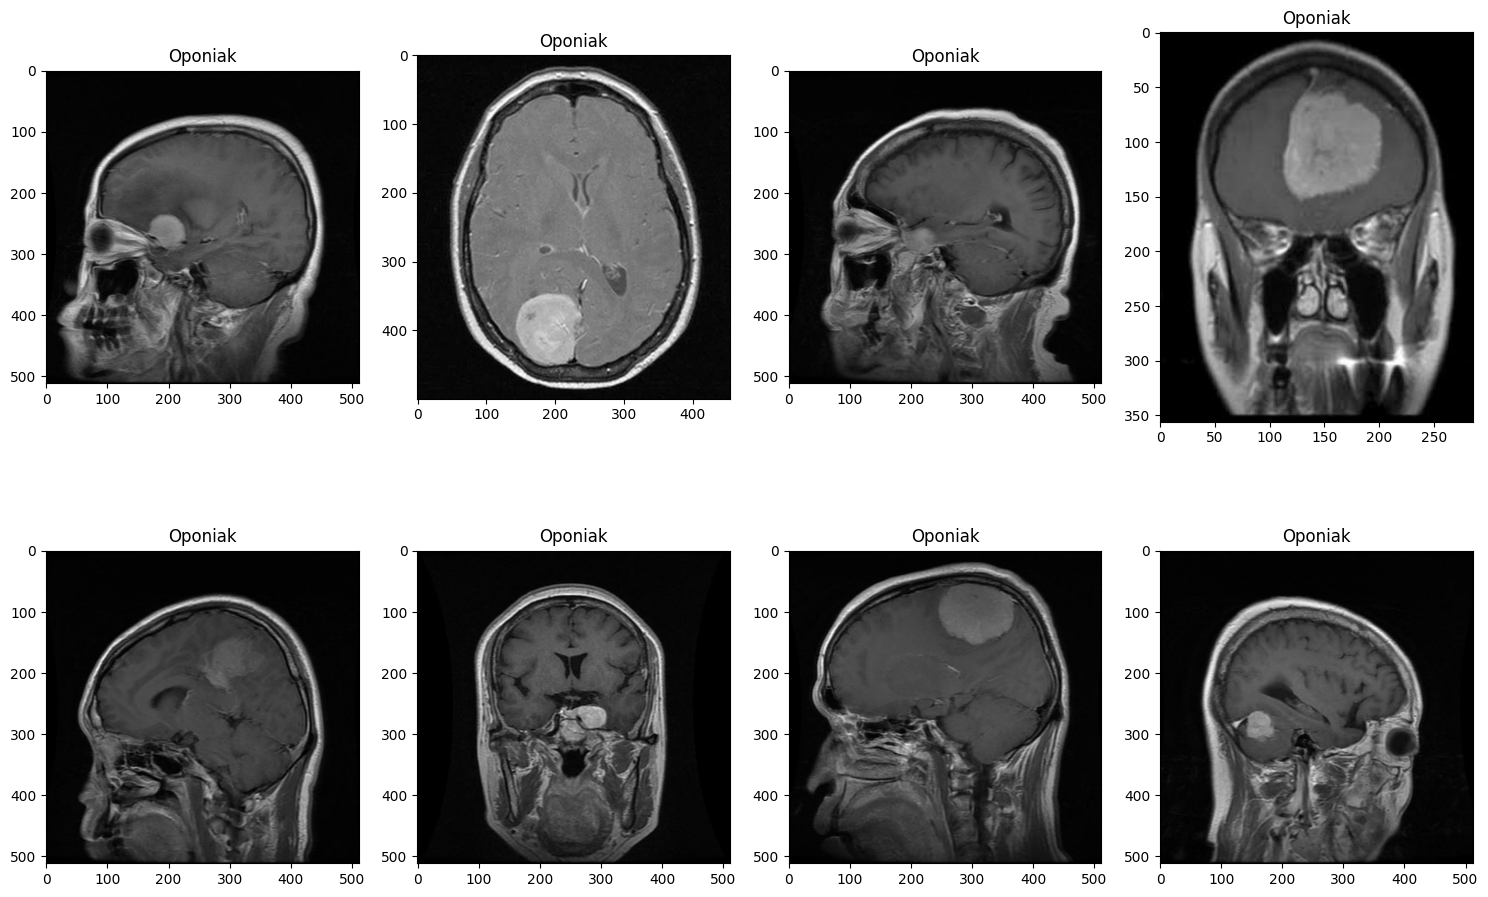

In [ ]:
meningioma_paths = tr_df[tr_df['Class'] == 'meningioma']['Class Path'].tolist()
random.seed(SEED)
random_meningioma_paths = random.sample(meningioma_paths, 8)

plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = Image.open(meningioma_paths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f'Oponiak')
plt.tight_layout()
plt.show()

## Oponiak (Meningioma)

### Czym jest?
- Oponiak to **łagodny nowotwór mózgu**, który rozwija się z **komórek opon mózgowo-rdzeniowych** (meningotelialnych).  
- Stanowi **ok. 30% wszystkich guzów wewnątrzczaszkowych**.  
- Zwykle rośnie powoli i często przez długi czas nie daje objawów.  

### Jak wygląda na obrazach medycznych?
- **Rezonans magnetyczny (MRI):**
  - Najlepiej uwidacznia oponiaka.
  - Guz zwykle izointensywny w obrazach T1 i T2.
  - Silnie kontrastuje po podaniu gadolinu.
  - Może powodować **ucisk i przemieszczenie struktur mózgowia**, ale rzadko nacieka tkankę nerwową.  

### Na co lekarze zwracają uwagę przy diagnozie?
1. **Lokalizacja guza** – przyczep do opony i jego relacja do struktur mózgu.  
2. **Obecność „dural tail sign”** – charakterystyczny objaw sugerujący oponiaka.  
3. **Granice guza** – zazwyczaj dobrze odgraniczony, co odróżnia go od glejaków.  
4. **Efekt masy** – stopień ucisku na sąsiednie tkanki, przemieszczenie komór mózgu lub powstawanie wodogłowia.  
5. **Wzorzec wzmocnienia kontrastowego** – jednolity i silny, typowy dla oponiaków.  
6. **Wpływ na kości czaszki** – możliwa hiperostoza (pogrubienie) sąsiadujących kości.  

### Podsumowanie
Oponiaka rozpoznaje się głównie na podstawie **charakterystycznego obrazu w MRI**: guz związany z oponą, dobrze odgraniczony, silnie kontrastujący, często z objawem „dural tail”. Diagnoza potwierdzana jest następnie badaniem histopatologicznym po operacji.  


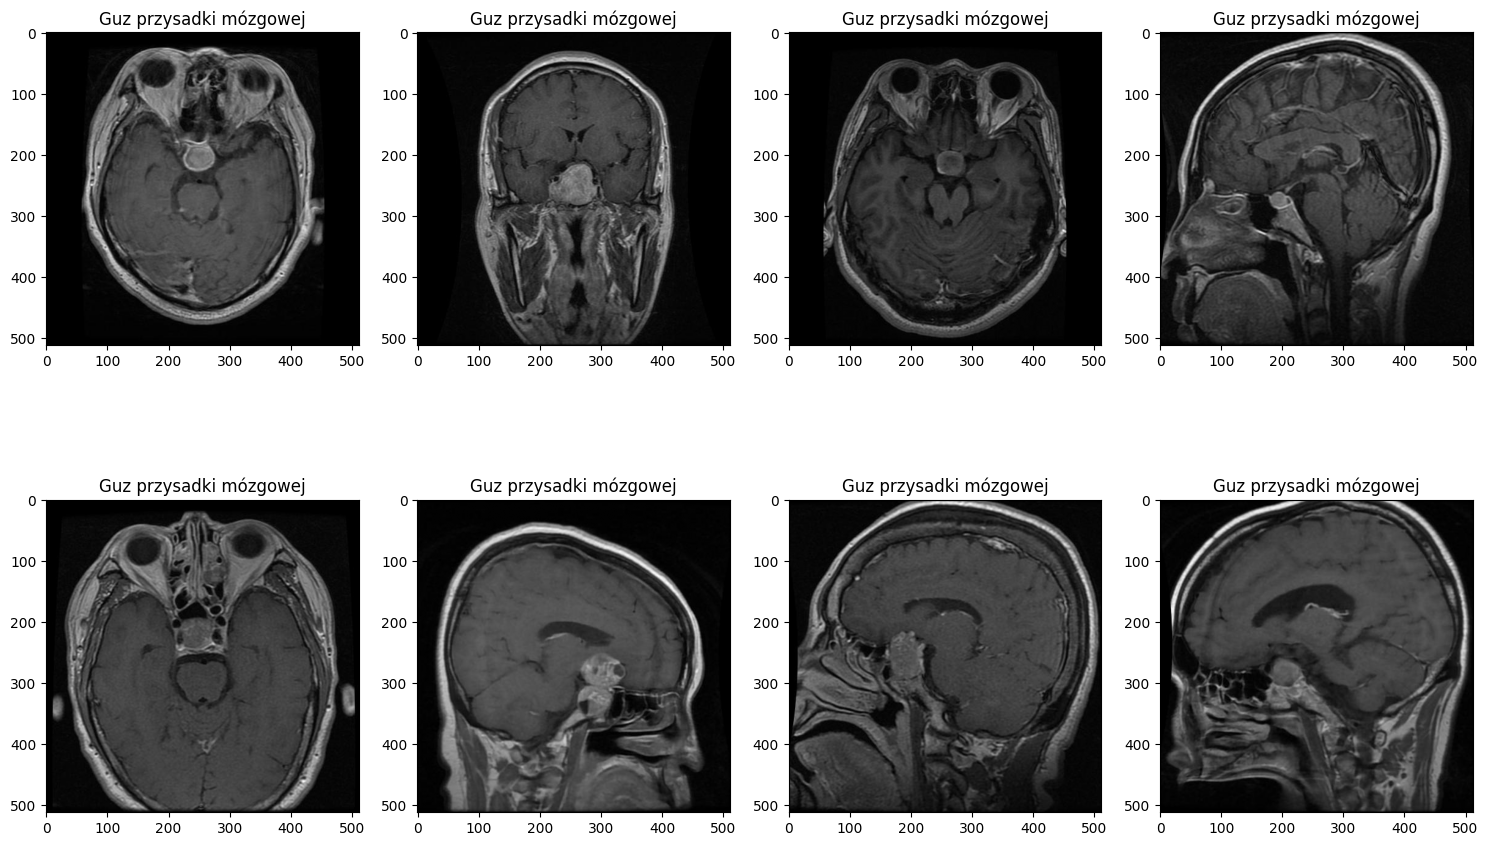

In [ ]:
pituitary_paths = tr_df[tr_df['Class'] == 'pituitary']['Class Path'].tolist()
random.seed(SEED)
random_pituitary_paths = random.sample(pituitary_paths, 8)

plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = Image.open(pituitary_paths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f'Guz przysadki mózgowej')
plt.tight_layout()
plt.show()

## Guz przysadki mózgowej (Pituitary tumor)

### Czym jest?
- Guz przysadki mózgowej to **nowotwór rozwijający się z komórek przysadki**, najczęściej w postaci **gruczolaka (adenoma)**.  
- Może być:
  - **czynny hormonalnie** – wydziela hormony (np. prolaktynę, ACTH, GH), powodując objawy endokrynologiczne,  
  - **nieczynny hormonalnie** – objawy wynikają głównie z ucisku na sąsiednie struktury.  
- Najczęściej lokalizuje się w **siodle tureckim** (sella turcica).

### Jak wygląda na obrazach medycznych?

#### Rezonans magnetyczny (MRI) – metoda z wyboru:
- **Mikrogruczolak** (< 10 mm):
  - Często hipointensywny w T1 i hiperintensywny w T2.  
  - Po podaniu kontrastu – widoczny jako obszar słabszego wzmocnienia w stosunku do prawidłowej przysadki.  
- **Makrogruczolak** (> 10 mm):
  - Wyraźnie poszerza siodło tureckie.  
  - Może uciskać na **skrzyżowanie nerwów wzrokowych** → charakterystyczne zaburzenia pola widzenia (niedowidzenie połowicze dwuskroniowe).  
  - Jednorodna lub niejednorodna masa, często dobrze odgraniczona.  

### Na co lekarze zwracają uwagę przy diagnozie?
1. **Rozmiar guza** – mikrogruczolak czy makrogruczolak.  
2. **Wpływ na skrzyżowanie wzrokowe** – ocena ryzyka zaburzeń widzenia.  
3. **Wzmocnienie kontrastowe** – charakterystyczny wzorzec w porównaniu do prawidłowej tkanki przysadki.  
4. **Wpływ na kości siodła tureckiego** – powiększenie lub destrukcja.  
5. **Ocena wydzielania hormonalnego** – korelacja z objawami klinicznymi (hiperprolaktynemia, akromegalia, Cushing).  

### Podsumowanie
Guz przysadki (najczęściej gruczolak) rozpoznaje się głównie w **MRI**. Charakteryzuje się obecnością masy w siodle tureckim, różnym wzmocnieniem kontrastowym i ewentualnym uciskiem na skrzyżowanie wzrokowe. Diagnoza obrazowa uzupełniana jest badaniami hormonalnymi.  


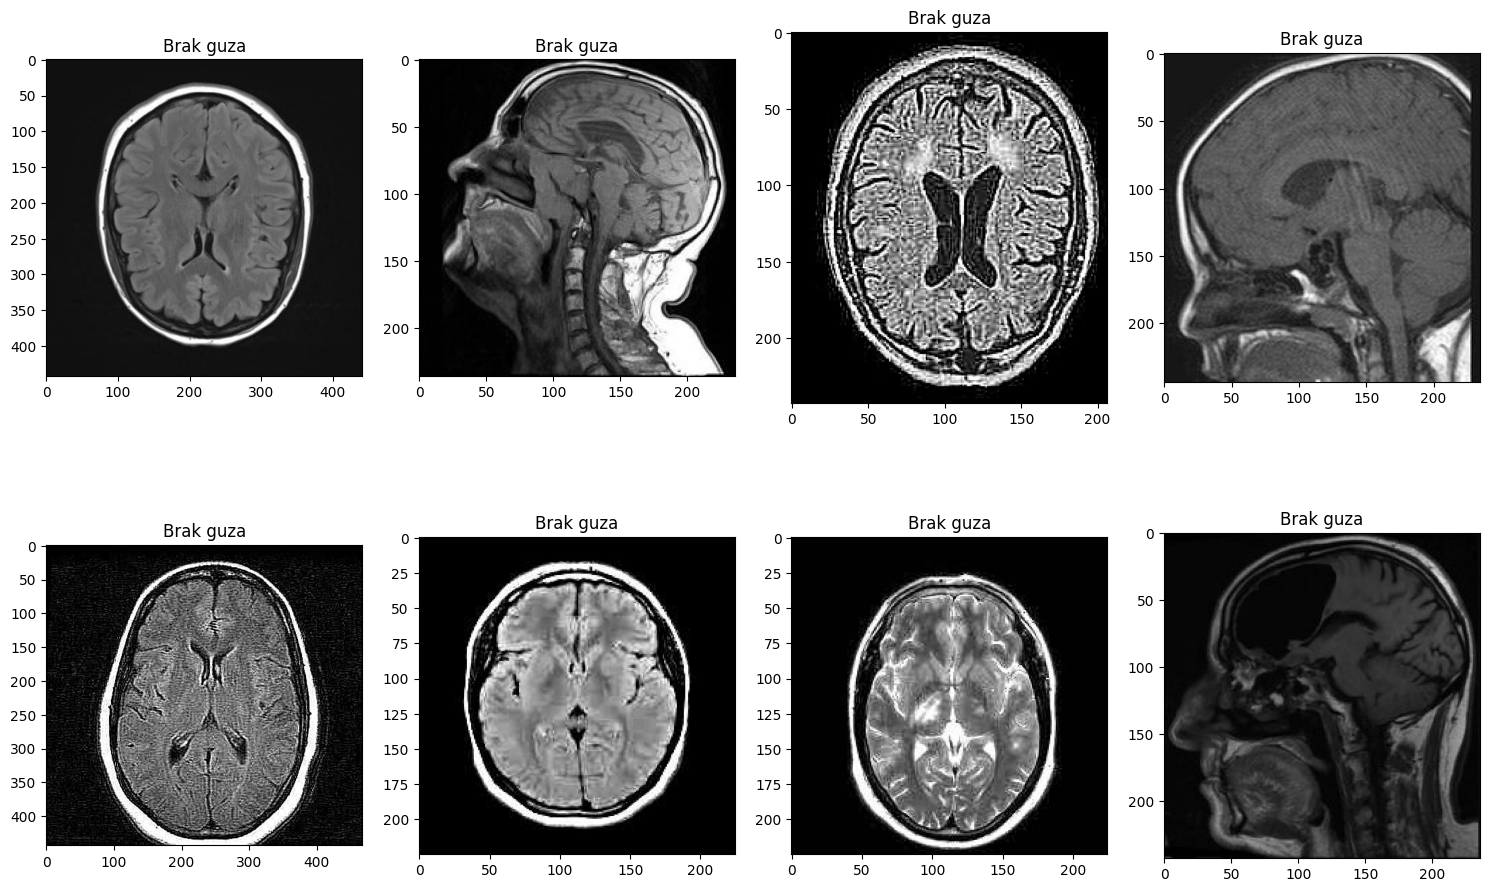

In [ ]:
notumor_paths = tr_df[tr_df['Class'] == 'notumor']['Class Path'].tolist()
random.seed(SEED)
random_notumor_paths = random.sample(notumor_paths,8)

plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = Image.open(notumor_paths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f'Brak guza')
plt.tight_layout()
plt.show()

## Prawidłowy obraz mózgu (brak guza)

### Czym jest?
- **Brak guza mózgu** oznacza, że w badaniach obrazowych (CT, MRI) **nie stwierdza się obecności patologicznej masy**.  
- Struktury mózgowia i opon są prawidłowe, bez oznak nacieku, ucisku czy przemieszczeń.  

### Jak wygląda na obrazach medycznych?

#### Rezonans magnetyczny (MRI):
- Struktury mózgu mają **prawidłową intensywność sygnału** we wszystkich sekwencjach (T1, T2, FLAIR).
- Brak ognisk patologicznego wzmocnienia po kontraście.
- Nie ma objawów **efektu masy**: ucisku, obrzęku, przemieszczeń ani wodogłowia.
- Opony mózgowe nie są pogrubiałe, nie kontrastują się nieprawidłowo.
- Kości czaszki bez cech nacieku lub hiperostozy.

### Na co lekarze zwracają uwagę przy ocenie?
1. **Symetria struktur** – obie półkule powinny wyglądać podobnie.  
2. **Brak ognisk kontrastujących** – nic nie wskazuje na obecność guza.  
3. **Układ komór mózgu** – prawidłowy, nieprzemieszczony.  
4. **Brak efektu masy** – brak ucisku na sąsiednie tkanki.  
5. **Jednorodny sygnał** – brak obszarów o innej intensywności w MRI lub CT.  

### Podsumowanie
W przypadku braku guza mózgu obraz MRI jest **prawidłowy**: struktury są symetryczne, brak patologicznego wzmocnienia, nie ma ucisku ani zmian ogniskowych. Taki wynik stanowi punkt odniesienia do porównania z obrazami, na których obecny jest guz.  


# Przygotowanie

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')